In [1]:
from scipy.stats import skewnorm
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

from scores.continuous import mse
from scores.continuous import flip_flop_index_proportion_exceeding, flip_flop_index

The Flip-Flop Index is a way of quantifying the stability of a forecast without penalising a trend. A trend will be be expected from a climatological forecast at longer lead-times to a more accurate, and possibly extreme, forecast at shorter lead times. The Flip-Flop Index has the same units as the forecast, with smaller values indicating greater stability. The Flip-Flop Index cannot be used to verify a forecast. Indeed, it does not use the verifying observation in its calculation. However, it describes an (arguably important) characteristic of a sequence of forecasts for an event. 

Read about the index at:  
Griffiths et al. (2019) "Flip-Flop Index: Quantifying Revision Stability for Fixed-Event Forecasts",  
*Meteorological Applications, 26(1), pp. 30-35.* [https://doi.org/10.1002/met.1732](https://doi.org/10.1002/met.1732)

And at:  
Griffiths D et al. (2021) "Circular Flip-Flop Index: quantifying revision stability of  forecasts of direction",  
*Journal of Southern Hemisphere Earth Systems Science 71(pp. 3), 266–271*  
[https://doi.org/10.1071/ES21010](https://doi.org/10.1071/ES21010)

The two functions showcased here are `flip_flop_index` which calculates the index for individual forecast revision series, and `flip_flop_index_proportion_exceding` which can be used to summarise the Flip-Flop Index values over many forecast revision series by reporting the frequency with which the Flip-Flop Index was observed to exceed values of interest.

In [1]:
# help(flip_flop_index)  # Uncomment this to see the help message

In [2]:
# help(flip_flop_index_proportion_exceeding)  # Uncomment this to see the help message

In [2]:
# Create two synthetic forecast revision series.
# These might represent a forecast of 28 degrees a week in advance of the event, updated daily with a forecast of 21 degrees the day before the event.
# Inspection shows that fcsta jumps around while fcst b has a cooler trend each day.
fcsta = xr.DataArray(data=[21., 23, 18, 20, 26, 25, 28], dims="lead_day", coords={"lead_day": np.arange(1, 8)})
fcstb = xr.DataArray(data=[21., 23, 23, 24, 25, 26, 28], dims="lead_day", coords={"lead_day": np.arange(1, 8)})

In [3]:
# The Flip-Flop Index of 1.8 for fcsta quantifies the lack of stability.
flip_flop_index(fcsta, "lead_day")

<xarray.DataArray ()>
array(1.8)
Attributes:
    sampling_dim:  lead_day

In [4]:
# The Flip-Flop Index for fcstb is 0, reflecting no flip-flopping.
flip_flop_index(fcstb, "lead_day")

<xarray.DataArray ()>
array(0.)
Attributes:
    sampling_dim:  lead_day

In [5]:
# Create synthetic temperature observations for 100 days and 100 locations (so, 10,000 observations)
# The values of the observations are between 0 and 40.
obs = 40 * np.random.random((100, 100))
obs = xr.DataArray(
    data=obs, 
    dims=["time", "location number"],
    coords={"time": pd.date_range("2023-01-01", "2023-04-10"), "location number": np.arange(0, 100)}
)

# Create forecasts for 7 lead days
# Each observation has 7 forecast values, issued between 1 and 7 days in advance.
# We create two such forecasts, initially matching the observations, then adding some noise to simulate a forecast
fcst1 = xr.DataArray(data=[1]*7, dims="lead_day", coords={"lead_day": np.arange(1, 8)})
fcst1 = fcst1 * obs
fcst2 = fcst1.copy()

# So, fcst1 is 70,000 forecasts, with 10,000 forecast revision sequences.
# Each forecast revision sequence is predicting one specific obeservation.
# Similarly for fcst2.

# Create some noise to add to the forecasts to make them interesting and more realistic.
# The noise increases with lead-day reflecting less accurate forecasts at longer lead-days.
noise = skewnorm.rvs(4, size=(1, 100, 100))
noise_for_fcst1 = noise.copy()
noise_for_fcst2 = noise.copy()
for lead_day in np.arange(1, 7):
    next_lead_day_noise = (1+lead_day/7)*skewnorm.rvs(4, size=(1, 100, 100))
    noise_for_fcst1 = np.concatenate((noise_for_fcst1, next_lead_day_noise))
    if lead_day % 2 == 0:
        noise_for_fcst2 = np.concatenate((noise_for_fcst2, -1*next_lead_day_noise))
    else:
        noise_for_fcst2 = np.concatenate((noise_for_fcst2, next_lead_day_noise))

# Add the noise to get the final forecasts.
fcst1 += noise_for_fcst1
fcst2 += noise_for_fcst2

In [6]:
# Calculate the Mean Square Error to confirm that the forecasts are less accurate at longer lead days
mse(fcst1, obs, preserve_dims=["lead_day"]).round(2)

<xarray.DataArray (lead_day: 7)>
array([1.  , 1.31, 1.67, 2.08, 2.51, 2.98, 3.45])
Coordinates:
  * lead_day  (lead_day) int64 1 2 3 4 5 6 7

In [7]:
# By design, fcst2 has the same absolute errors as fcst1, and hence the same mean square errors.
mse(fcst2, obs, preserve_dims=["lead_day"]).round(2)

<xarray.DataArray (lead_day: 7)>
array([1.  , 1.31, 1.67, 2.08, 2.51, 2.98, 3.45])
Coordinates:
  * lead_day  (lead_day) int64 1 2 3 4 5 6 7

In [8]:
# We can use the flip_flop_index to calculate the Flip-Flop Index for the revision sequence for each date and location.
flip_flop_index(fcst1, "lead_day").round(2)

<xarray.DataArray (time: 100, location number: 100)>
array([[0.44, 0.58, 0.59, ..., 0.72, 0.36, 0.39],
       [0.25, 1.18, 0.46, ..., 0.36, 0.2 , 0.62],
       [0.63, 0.49, 0.24, ..., 0.44, 0.7 , 0.63],
       ...,
       [0.61, 0.4 , 0.58, ..., 1.58, 1.21, 1.1 ],
       [0.64, 1.12, 0.68, ..., 0.74, 0.75, 1.5 ],
       [0.69, 0.19, 0.71, ..., 1.05, 0.65, 0.53]])
Coordinates:
  * time             (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-04-10
  * location number  (location number) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Attributes:
    sampling_dim:  lead_day

In [9]:
# We expect fcst2 to be less stable (have more flip-flopping) that fcst1.
# Calculating the frequency with with the Flip-Flop Index exceeds 1 confirms that
# the Flip-Flop index for exceeds 1 only about 20% of the time for fcst1, but well over 80% of the time for fcst2.
# The exact values depend on the random noise generated each time this notebook is run.
print(flip_flop_index_proportion_exceeding(fcst1, "lead_day", [1]).values)
print(flip_flop_index_proportion_exceeding(fcst2, "lead_day", [1]).values)

[0.1866]
[0.8581]


Text(0.5, 1.0, 'Lead Days 1-2-3-4-5-6-7')

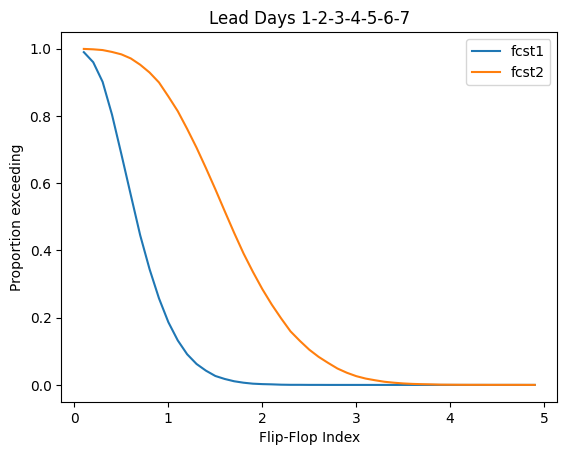

In [10]:
# You can display a graph showing the proportion of times the Flip-Flop exceeds the x-value as is done here.
# We are calculating `flip_flop_index_proportion_exceeding` each of 0.1, 0.2, 0.3 etc.
# The lower line represents the comparative stability fcst1 with the higher line representing the jumpiness of fcst2 as a system.
# Many of fcst2 have a Flip-Flop index exceeding 2 but barely any of fcst1.
flip_flop_index_proportion_exceeding(fcst1, "lead_day", np.arange(0.1, 5, 0.1)).plot()
flip_flop_index_proportion_exceeding(fcst2, "lead_day", np.arange(0.1, 5, 0.1)).plot()
plt.legend(['fcst1', 'fcst2'])
plt.xlabel("Flip-Flop Index")
plt.ylabel("Proportion exceeding")
plt.title('Lead Days 1-2-3-4-5-6-7')

Text(0.5, 1.0, 'fcst1')

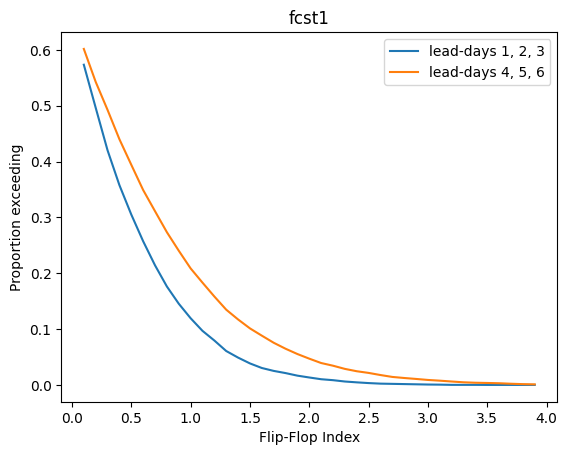

In [11]:
# Considering just fcst1, we can compare the Flip-Flop Index of three forecasts in the revision series.
# We see here that the shorter lead-day forecasts Flip-Flop slightly less than the longer range forecasts.
flip_flop_index_proportion_exceeding(fcst1, "lead_day", np.arange(0.1, 4, 0.1), days123=[1, 2, 3]).days123.plot()
flip_flop_index_proportion_exceeding(fcst1, "lead_day", np.arange(0.1, 4, 0.1), days456=[4, 5, 6]).days456.plot()
plt.legend(['lead-days 1, 2, 3', 'lead-days 4, 5, 6'])
plt.xlabel("Flip-Flop Index")
plt.ylabel("Proportion exceeding")
plt.title('fcst1')

Next Steps:

Try on some real data of interest.

Try on some forecasts of direction using the flag `is_angular`

For `flip_flop_index_proportion_exceeding` try the `reduce_dims` or `preserve_dims` to report data conditioned by something of interest. For example, if your data includes `season` or `forecast zone` you can report exceedence values for those.

It is not appropriate to consider the Flip-Flop Index from forecast revision sequences of different lengths. Do you agree?